In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, confusion_matrix
import itertools
from pprint import pprint
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')
np.random.seed(0)

In [2]:
# Define Evaluation
def evaluate(model, X_train, y_train, X_test, y_test):
    predictions_train_set= model.predict(X_train)
    predictions_test_set = model.predict(X_test)
    
    print('True lables:     ', list(y_test))
    print('Predicted labels:', list(predictions_test_set))
    print('**********************************************************')
    print('Model Performance', model)
    print('Accuracy on train_set %.2f' % accuracy_score(y_train, model.predict(X_train)))
    print('Accuracy on test_set %.2f' % accuracy_score(y_test, model.predict(X_test)))
    print('**********************************************************')
    print(classification_report(y_train, predictions_train_set))
   

In [3]:
# Define Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Loading the dataset
df = pd.read_excel('Melina_OriginalFile.xlsx', skiprows=2)
df = df.drop(df.index[0:6]).reset_index(drop=True)

In [5]:
# Capitalizing all enteries to make them consistent
df[['PVD','BMI','Venous insufficiency','CHF','Presence of ENE', 'Adjuvant radiation', 'Adjuvant systemic treatment','Lymphedema','Location','Preexisting edema','Preexisting neurologic compromise']] = df[['PVD','BMI','Venous insufficiency','CHF','Presence of ENE', 'Adjuvant radiation', 'Adjuvant systemic treatment','Lymphedema','Location','Preexisting edema','Preexisting neurologic compromise']].applymap(lambda x: x.capitalize())

In [6]:
# Removing extra white spaces
df = df.applymap(lambda x: x.strip() if type(x)==str else x)

In [7]:
# Dropped columns with constant values
df = df.drop(columns=['PVD', 'Venous insufficiency'])

In [8]:
# Replace values in columns to make the entries consistent 
df = df.replace(['Nr','?','Not Applicable'], np.nan)
df['Size of largest nodal tumor deposit'] = df['Size of largest nodal tumor deposit'].replace(['Negative'], np.nan)
df['Highest/deepest level of LN dissection'] = df['Highest/deepest level of LN dissection'].replace({
    'II': 'II/Superficial', 
    'Superficial': 'II/Superficial', 
    'III': 'III/Deep', 
    'Deep':'III/Deep'})

df['Lymphedema_'] = df['Lymphedema']
df['Lymphedema'] = df['Lymphedema'].replace({'No': "No", 'Permanent':'Yes', 'Transient':'Yes'})

In [9]:
df.head(10)

,Patient,Age at diagnosis,Gender,BMI,CHF,Preexisting edema,Preexisting neurologic compromise,Location,Breslow of 1ry,Clark of 1ry,...,Highest/deepest level of LN dissection,Size of largest nodal tumor deposit,N number,Presence of ENE,Adjuvant radiation,Adjuvant systemic treatment,Lymphedema,Supportive care,Length of F/U,Lymphedema_
0,1.0,34,F,Normal,No,No,No,Chest,15.00,V,...,III/Deep,10.0,18.0,No,No,Immuno,No,NaN,7,No
1,2.0,66,M,Normal,No,No,No,Unknown,NaN,NaN,...,III/Deep,55.0,39.0,Yes,No,Immuno,No,NaN,7,No
2,3.0,85,M,Overweight,No,No,No,Shoulder,2.00,IV,...,II/Superficial,11.0,23.0,Yes,Yes,No,No,NaN,6,No
3,4.0,61,F,Overweight,No,No,No,Arm,10.50,V,...,III/Deep,38.0,18.0,Yes,No,Targeted tx,No,NaN,7,No
4,5.0,39,F,Normal,No,No,No,Forearm,0.71,III,...,III/Deep,NaN,10.0,No,No,Targeted tx,No,NaN,7,No
5,6.0,72,F,Overweight,No,No,No,Neck,1.05,IV,...,II/Superficial,61.0,20.0,Yes,No,Immuno,No,NaN,11,No
6,7.0,56,M,Overweight,No,No,No,Scapula,NaN,NaN,...,III/Deep,55.0,37.0,NaN,No,Immuno,No,NaN,11,No
7,8.0,84,M,Normal,Yes,No,No,Toe,6.50,V,...,III/Deep,4.0,22.0,No,No,No,No,NaN,4,No
8,9.0,71,F,Overweight,No,No,No,Buttock,3.80,IV,...,III/Deep,NaN,8.0,NaN,No,Immuno,Yes,Both,14,Permanent
9,10.0,65,M,NaN,No,Yes,No,Toe,3.90,IV,...,III/Deep,75.0,20.0,Yes,Yes,Immuno,Yes,None,17,Transient


In [10]:
df['Patient'] = df['Patient'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Patient                                 66 non-null     object 
 1   Age at diagnosis                        66 non-null     int64  
 2   Gender                                  66 non-null     object 
 3   BMI                                     65 non-null     object 
 4   CHF                                     66 non-null     object 
 5   Preexisting edema                       66 non-null     object 
 6   Preexisting neurologic compromise       66 non-null     object 
 7   Location                                66 non-null     object 
 8   Breslow of 1ry                          54 non-null     float64
 9   Clark of 1ry                            48 non-null     object 
 10  Type of LN dissection                   66 non-null     object 


In [11]:
df.shape

(66, 21)

In [12]:
df.columns

Index(['Patient', 'Age at diagnosis', 'Gender', 'BMI', 'CHF',
       'Preexisting edema', 'Preexisting neurologic compromise', 'Location',
       'Breslow of 1ry', 'Clark of 1ry', 'Type of LN dissection',
       'Highest/deepest level of LN dissection',
       'Size of largest nodal tumor deposit', 'N number', 'Presence of ENE',
       'Adjuvant radiation', 'Adjuvant systemic treatment', 'Lymphedema',
       'Supportive care', 'Length of F/U', 'Lymphedema_'],
      dtype='object')

# Missing Data

##### Includes N/As

In [13]:
# Counting the number of missing values in each column
missing_cols = df.isnull().sum()
missing_cols = missing_cols[missing_cols > 0].index
temp = pd.DataFrame(df[missing_cols].isnull().sum()).reset_index()
temp.columns = ["Column", "Missing"]
temp

,Column,Missing
0,BMI,1
1,Breslow of 1ry,12
2,Clark of 1ry,18
3,Size of largest nodal tumor deposit,11
4,Presence of ENE,5
5,Adjuvant radiation,1
6,Adjuvant systemic treatment,1
7,Supportive care,48


In [14]:
df_melt = pd.melt(df, id_vars=['Lymphedema'], value_vars=['Size of largest nodal tumor deposit', 'N number'])

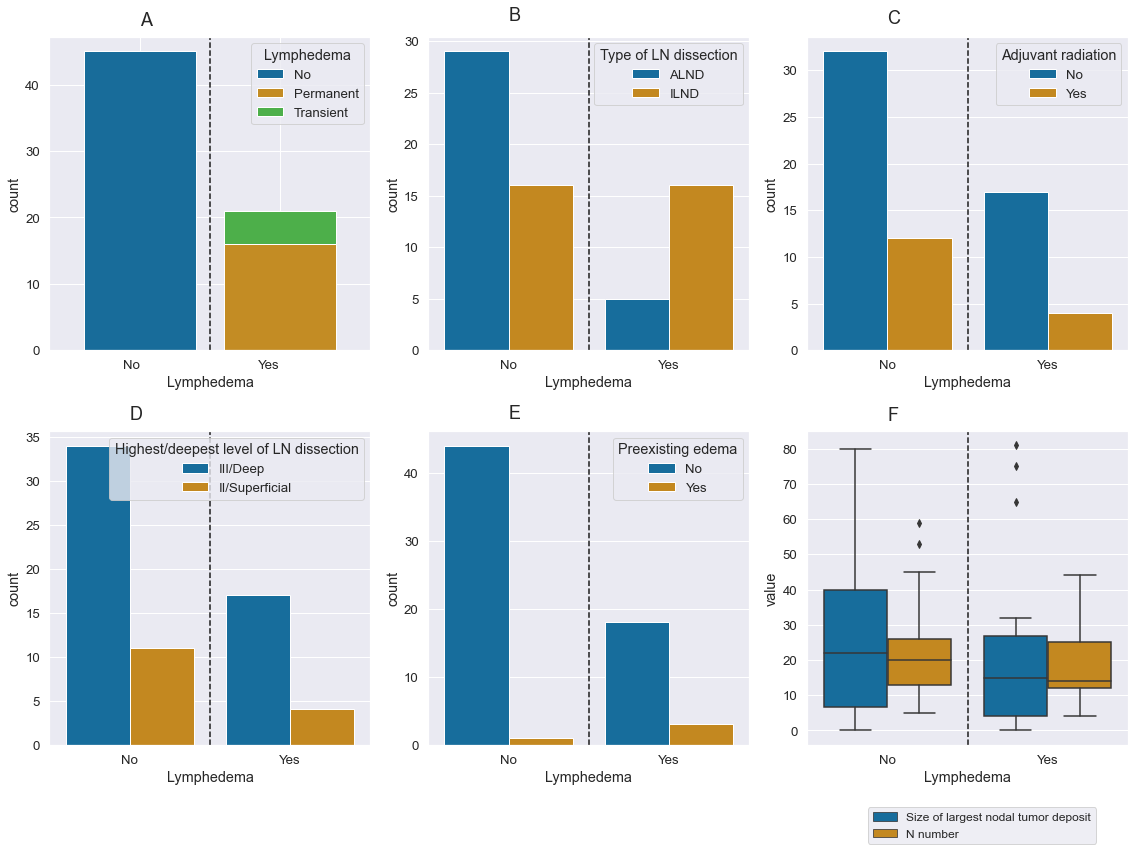

In [16]:
sns.set(font_scale=1.2) 
f, axes = plt.subplots(2, 3, figsize=(16, 12), sharex=False, sharey=False)

sns.countplot(x="Lymphedema",  data=df, ax=axes[0, 0], palette="colorblind");


df_plot.plot(kind='bar', stacked=True, width = 0.8, color=['#186C9A', '#C38C24', '#4daf4a'], ax=axes[0, 0])
axes[0, 0].legend(title='Lymphedema')
for label in axes[0, 0].get_xticklabels():
    label.set_ha("right")
    label.set_rotation(0)

sns.countplot(x='Lymphedema', hue='Type of LN dissection', data=df, ax=axes[0, 1], palette="colorblind")


sns.countplot(x='Lymphedema', hue='Adjuvant radiation', data=df, ax=axes[0, 2], palette="colorblind")
sns.countplot(x='Lymphedema', hue='Highest/deepest level of LN dissection', data=df, ax=axes[1, 0], palette="colorblind")
sns.countplot(x='Lymphedema', hue='Preexisting edema', data=df, ax=axes[1, 1], palette="colorblind");
sns.boxplot(x='Lymphedema', y='value', hue='variable', data=df_melt, palette='colorblind', ax=axes[1, 2])
# Putting the legend down
plt.legend(bbox_to_anchor=(0.9, -0.2),  borderaxespad=0, fontsize=12)

# Adding vertical lines
[axes[0,0].axvline(x, color = 'k', linestyle='--') for x in [.5]]
[axes[0,1].axvline(x, color = 'k', linestyle='--') for x in [.5]]
[axes[0,2].axvline(x, color = 'k', linestyle='--') for x in [.5]]
[axes[1,0].axvline(x, color = 'k', linestyle='--') for x in [.5]]
[axes[1,1].axvline(x, color = 'k', linestyle='--') for x in [.5]]
[axes[1,2].axvline(x, color = 'k', linestyle='--') for x in [.5]]

axes[0,0].text(0, 49,'A', fontsize=18) #add text
axes[0,1].text(0, 32,'B', fontsize=18) #add text
axes[0,2].text(0, 35,'C', fontsize=18) #add text

axes[1,0].text(0, 37,'D', fontsize=18) #add text
axes[1,1].text(0, 48,'E', fontsize=18) #add text
axes[1,2].text(0, 88,'F', fontsize=18) #add text

plt.savefig('Fig2-lowres.tiff', dpi=200)
plt.tight_layout();


# Machine Learning

In [17]:
# Feature Selection
df_new = df[[#'N number', 
        'Size of largest nodal tumor deposit',
        'Type of LN dissection',
        'Adjuvant radiation', 
        'Highest/deepest level of LN dissection',
        'Lymphedema']].dropna()
X=df_new[[#'N number', 
        'Size of largest nodal tumor deposit',
        'Type of LN dissection',
        'Adjuvant radiation', 
        'Highest/deepest level of LN dissection'
        ]].values

y = df_new['Lymphedema']

In [18]:
X[0:5]

array([[10.0, 'ALND', 'No', 'III/Deep'],
       [55.0, 'ALND', 'No', 'III/Deep'],
       [11.0, 'ALND', 'Yes', 'II/Superficial'],
       [38.0, 'ALND', 'No', 'III/Deep'],
       [61.0, 'ALND', 'No', 'II/Superficial']], dtype=object)

In [19]:
# Encoding data to dummy variables
le = preprocessing.LabelEncoder()
X[:,1] = le.fit_transform(X[:,0].astype(str))
X[:,2] = le.fit_transform(X[:,1].astype(str))
X[:,3] = le.fit_transform(X[:,3].astype(str))

In [20]:
# Normalizing the data
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.62748824, -1.09988158,  1.40912269,  0.56309251],
       [ 1.26117877,  0.95407595,  0.37222109,  0.56309251],
       [-0.58551786, -1.01430001,  1.48888436, -1.77590714],
       [ 0.54768234,  0.52616813, -0.10634888,  0.56309251],
       [ 1.51300104,  1.2964022 ,  0.69126774, -1.77590714]])

In [21]:
# Splitting data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (43, 4) (43,)
Test set: (11, 4) (11,)


# Dealing with imbalanced dataset
Synthetic Minority Oversampling Technique, or SMOTE.

In [22]:
oversample = SMOTE(k_neighbors=2)
# fit predictor and target variable
X_ros, y_ros = oversample.fit_resample(X_train, y_train)
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

# X_ros, y_ros are now used instead of X_train and y_train

Original dataset shape Counter({'No': 30, 'Yes': 13})
Resample dataset shape Counter({'Yes': 30, 'No': 30})


# Logistic Regression

In [23]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']  #Also tested for 'l1','elasticnet','none' --Results were the same
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_ros, y_ros)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print('******************************************************************************************')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Avg Accuracy: %f Std: %f with: %r" % (mean, stdev, param))

Best: 0.566667 using {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
******************************************************************************************
Avg Accuracy: 0.500000 Std: 0.155158 with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Avg Accuracy: 0.500000 Std: 0.155158 with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Avg Accuracy: 0.500000 Std: 0.155158 with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Avg Accuracy: 0.500000 Std: 0.155158 with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Avg Accuracy: 0.500000 Std: 0.155158 with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Avg Accuracy: 0.500000 Std: 0.155158 with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Avg Accuracy: 0.505556 Std: 0.145827 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Avg Accuracy: 0.505556 Std: 0.145827 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Avg Accuracy: 0.505556 Std: 0.145827 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
Avg A

In [24]:
LR_clf = LogisticRegression(solver='liblinear', penalty='l2', C=0.01)
LR_clf.fit(X_ros, y_ros)
evaluate (LR_clf, X_ros, y_ros, X_test, y_test)

True lables:      ['Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No']
Predicted labels: ['Yes', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'Yes', 'Yes', 'No']
**********************************************************
Model Performance LogisticRegression(C=0.01, solver='liblinear')
Accuracy on train_set 0.62
Accuracy on test_set 0.55
**********************************************************
              precision    recall  f1-score   support

          No       0.77      0.33      0.47        30
         Yes       0.57      0.90      0.70        30

    accuracy                           0.62        60
   macro avg       0.67      0.62      0.58        60
weighted avg       0.67      0.62      0.58        60



# Random Forest

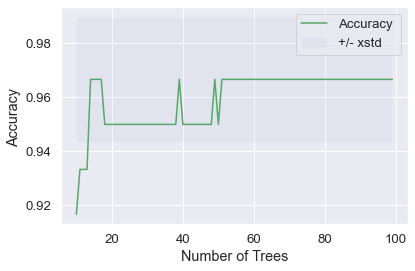

In [25]:
#Tuning the number of trees
n=100
n_Trees, acc, std = [],[],[]
for n in range(10,n,1):
    
    #Train Model and Predict  
    rf_clf = RandomForestClassifier(n_estimators = n, random_state=30).fit(X_ros,y_ros)
    PredRandomForest_training=rf_clf.predict(X_ros)
    accuracy = accuracy_score(y_ros, PredRandomForest_training) 
    standard_deviation=np.std(PredRandomForest_training==y_ros)/np.sqrt(PredRandomForest_training.shape[0])
    acc.append(accuracy)
    n_Trees.append(n)
    std.append(standard_deviation)

#Plotting the overall accuracy versus number of trees. 
plt.plot(n_Trees,acc,'g')
plt.fill_between(n_Trees,accuracy - 1 * standard_deviation, accuracy + 1 * standard_deviation, alpha=0.05)
plt.legend(('Accuracy ', '+/- xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Trees')
plt.tight_layout()
plt.show()

In [26]:
##Tuning other parameters

# RANDOM SEARCH
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50] # Found above
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=30, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_ros, y_ros)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50]},
                   random_state=30, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [29]:
rf_clf=RandomForestClassifier(n_estimators= 50, 
                              min_samples_split= 2, 
                              min_samples_leaf= 1, 
                              max_features= 'sqrt', 
                              max_depth= 70, 
                              bootstrap= True, 
                              random_state=30)

rf_clf.fit(X_ros,y_ros)
evaluate (rf_clf, X_ros, y_ros, X_test, y_test)

True lables:      ['Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No']
Predicted labels: ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'Yes', 'No']
**********************************************************
Model Performance RandomForestClassifier(max_depth=70, max_features='sqrt', n_estimators=50,
                       random_state=30)
Accuracy on train_set 0.95
Accuracy on test_set 0.64
**********************************************************
              precision    recall  f1-score   support

          No       0.94      0.97      0.95        30
         Yes       0.97      0.93      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



# K-Nearest Neighbors

Ks: 2 --> mean_accuracy: 0.5999999999999999
Ks: 3 --> mean_accuracy: 0.6
Ks: 4 --> mean_accuracy: 0.5833333333333334
Ks: 5 --> mean_accuracy: 0.6666666666666666
Ks: 6 --> mean_accuracy: 0.5999999999999999
Ks: 7 --> mean_accuracy: 0.5666666666666667
Ks: 8 --> mean_accuracy: 0.6166666666666666
Ks: 9 --> mean_accuracy: 0.6333333333333334


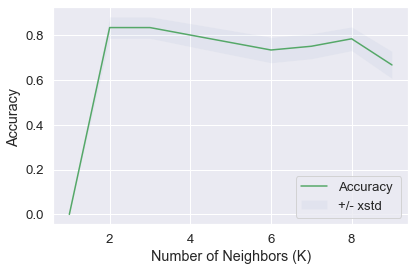

In [30]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for n in range(2,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_ros,y_ros)
    
    # 10-fold Cross Validation
    scores = cross_val_score(neigh, X_ros,y_ros, cv=10, scoring='accuracy')
    print('Ks:' ,n, '--> mean_accuracy:', scores.mean())
    Predneigh=neigh.predict(X_ros)
    mean_acc[n-1] = accuracy_score(y_ros, Predneigh)

    
    std_acc[n-1]=np.std(Predneigh==y_ros)/np.sqrt(Predneigh.shape[0])

# Plotting the overall accuracy versus number of neighbors. 
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.05)
plt.legend(('Accuracy ', '+/- xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [31]:
# The highest accuracy is achieved at k=20.
ks = 2
#Train Model and Predict  
neigh_clf = KNeighborsClassifier(n_neighbors = ks).fit(X_ros,y_ros) #X_train,y_train

Predneigh = neigh_clf.predict(X_test)

In [32]:
evaluate (neigh_clf, X_ros, y_ros, X_test, y_test)

True lables:      ['Yes', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No']
Predicted labels: ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No']
**********************************************************
Model Performance KNeighborsClassifier(n_neighbors=2)
Accuracy on train_set 0.83
Accuracy on test_set 0.73
**********************************************************
              precision    recall  f1-score   support

          No       0.75      1.00      0.86        30
         Yes       1.00      0.67      0.80        30

    accuracy                           0.83        60
   macro avg       0.88      0.83      0.83        60
weighted avg       0.88      0.83      0.83        60



Confusion matrix, without normalization
[[4 4]
 [1 2]]


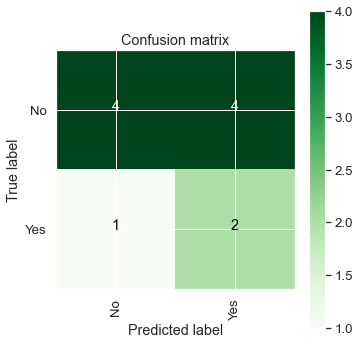

In [33]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR_clf.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],normalize=False)

Confusion matrix, without normalization
[[6 2]
 [2 1]]


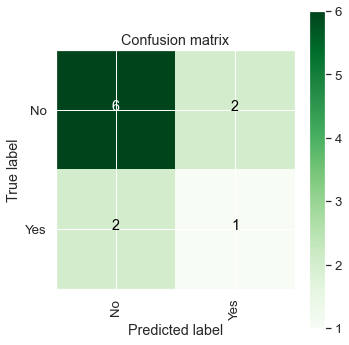

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_clf.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],normalize=False)

Confusion matrix, without normalization
[[7 1]
 [2 1]]


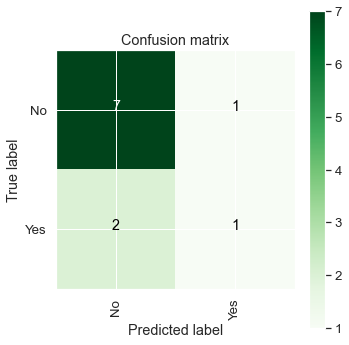

In [35]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, neigh_clf.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['No','Yes'],normalize=False)